In [1]:
import numpy as np
import pandas as pd
from itertools import combinations
import time

In [49]:
def dtw_distance(x, y):
    
    n = np.shape(x)[0] + 1 # 384 + 1
    m = np.shape(y)[0] + 1 # 384 + 1
    
    DTW = np.zeros((n, m))
    DTW[:, 0] = float('Inf')
    DTW[0, :] = float('Inf')
    DTW[0, 0] = 0
           
    for i in range(1, n): # i: 1,2,...,384
        for j in range(1, m):
            #cost = d(x[i-1], y[j-1])
            cost = np.linalg.norm(x[i-1] - y[j-1])
            DTW[i, j] = cost + min(DTW[i-1, j], DTW[i, j-1], DTW[i-1, j-1])

    return DTW[n-1, m-1]

In [4]:
x=np.array([2,3,5])
y=np.array([1,2,3])
abs(x-y)

array([1, 1, 2])

In [7]:
n=3
m=4
DTW = np.zeros((n, m))
DTW[:, 0] = float('Inf')
DTW[0, :] = float('Inf')
DTW[0, 0] = 1

In [8]:
print(DTW)

[[ 1. inf inf inf]
 [inf  0.  0.  0.]
 [inf  0.  0.  0.]]


In [10]:
DTW[2,3] = 3
print(DTW)

[[ 1. inf inf inf]
 [inf  0.  0.  0.]
 [inf  0.  0.  3.]]


In [12]:
np.sqrt(2)

1.4142135623730951

In [39]:
a = np.ones((5,3))
b = np.zeros((5,3))

In [42]:
a[0][1]

1.0

In [43]:
a[0]

array([1., 1., 1.])

In [44]:
b[0]

array([0., 0., 0.])

In [47]:
np.linalg.norm(a[0]-b[0])

1.7320508075688772

In [48]:
np.sqrt(3)

1.7320508075688772

#### Custom K means

In [1]:
import matplotlib.pyplot as plt
from matplotlib import style
style.use('ggplot')
import numpy as np
from sklearn.cluster import KMeans

In [62]:
X = np.array([[1,2],
              [1.5, 1.8],
              [5, 8],
              [8, 8],
              [1, 0.6],
              [9, 11]])
print(X.shape)

(6, 2)


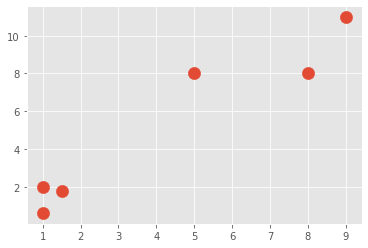

In [63]:
plt.scatter(X[:,0], X[:,1], s=150)
plt.show()
colors = 10*["g","r","c","b","k"]

In [65]:
class K_Means:
    def __init__(self, k=2, tol=0.001, max_iter=300):
        self.k = k
        self.tol = tol
        self.max_iter = max_iter
        
    def fit(self, data):
        
        self.centroids = {}
        
        for i in range(self.k):
            self.centroids[i] = data[i]
            
        for i in range(self.max_iter):
            self.classifications = {}
            
            for i in range(self.k):
                self.classifications[i] = []
                
            for featureset in data:
                distances = [np.linalg.norm(featureset-self.centroids[centroid]) for centroid in self.centroids]
                classification = distances.index(min(distances))
                self.classifications[classification].append(featureset)
            
            prev_centroids = dict(self.centroids)
        
            for classification in self.classifications:
                self.centroids[classification] = np.average(self.classifications[classification], axis=0)
            
            optimized = True
            
            for c in self.centroids:
                original_centroid = prev_centroids[c]
                current_centroid = self.centroids[c]
                if np.sum((current_centroid-original_centroid)/original_centroid*100.0)>self.tol:
                    optimized = False
        
    def predict(self, data):
        distances = [np.linalg.norm(data-self.centroids[centroid]) for centroid in self.centroids]
        classification = distances.index(min(distances))
        return classification

In [66]:
clf = K_Means()
clf.fit(X)

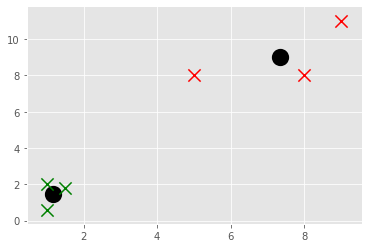

In [67]:
for centroid in clf.centroids:
    plt.scatter(clf.centroids[centroid][0], clf.centroids[centroid][1], marker="o", color="k", s=150, linewidths=5)

for classification in clf.classifications:
    color = colors[classification]
    for featureset in clf.classifications[classification]:
        plt.scatter(featureset[0], featureset[1], marker="x", color=color, s=150, linewidths=5)
plt.show()

<function matplotlib.pyplot.show(*args, **kw)>

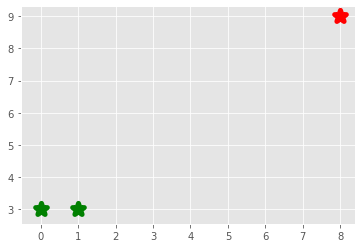

In [69]:
unknowns = np.array([[1,3],
                     [8,9],
                     [0,3]])
for unknown in unknowns:
    classification = clf.predict(unknown)
    plt.scatter(unknown[0], unknown[1], marker="*", color=colors[classification], s=150, linewidths=5)

plt.show


In [64]:
for featureset in X:
    print(featureset)

[1. 2.]
[1.5 1.8]
[5. 8.]
[8. 8.]
[1.  0.6]
[ 9. 11.]


#### K means using DTW

In [2]:
import matplotlib.pyplot as plt
from matplotlib import style
style.use('ggplot')
import numpy as np
from sklearn.cluster import KMeans
import os
import pickle

In [3]:
# load numpy
file_dir = 'C:/Users/user/Dropbox/Trust/HAR_Sample_Code/data_numpy/inertial/'
actions = ['a5', 'a7', 'a12', 'a15', 'a18', 'a16']
numpy_files = {}
for i in range(len(actions)):
    action = actions[i]
    numpy_files[action] = [os.path.join(file_dir,i) for i in (os.listdir(file_dir)) if action in i]
    
data_files = {}
for k in range(len(actions)):
    data_files[actions[k]] = [np.load(i) for i in numpy_files[actions[k]]]    
length = 280
proc_ax = np.empty((32*len(actions),length), dtype=float)
proc_ay = np.empty((32*len(actions),length), dtype=float)
proc_az = np.empty((32*len(actions),length), dtype=float)
proc_total_acc = np.empty((32*len(actions),length), dtype=float)
print(np.shape(proc_ax))

(192, 280)


In [4]:
for j in range(len(actions)):
    for i in range(len(data_files[actions[j]])):
            data = data_files[actions[j]][i]
            ax = data[:,0]
            ay = data[:,1]
            az = data[:,2]

            data_len = np.shape(data)[0]
            if data_len%2==0:
                interval = length - data_len
            else:
                interval = length - (data_len + 1)
                
            half_interval = int(interval / 2)
            
            left_redundancy = ax[0]*np.ones((half_interval,))
            right_redundancy = ax[-1]*np.ones((half_interval,))
            ax_extended = np.concatenate((left_redundancy, ax, right_redundancy))
            
            left_redundancy = ay[0]*np.ones((half_interval,))
            right_redundancy = ay[-1]*np.ones((half_interval,))
            ay_extended = np.concatenate((left_redundancy, ay, right_redundancy))
            
            left_redundancy = az[0]*np.ones((half_interval,))
            right_redundancy = az[-1]*np.ones((half_interval,))
            az_extended = np.concatenate((left_redundancy, az, right_redundancy))
            
            if data_len%2==1:
                ax_extended = np.concatenate((ax_extended, ax_extended[-1]*np.ones((1,))))
                ay_extended = np.concatenate((ay_extended, ay_extended[-1]*np.ones((1,))))
                az_extended = np.concatenate((az_extended, az_extended[-1]*np.ones((1,))))
            
            proc_ax[i+j*32] = ax_extended
            proc_ay[i+j*32] = ay_extended
            proc_az[i+j*32] = az_extended
            proc_total_acc[i+j*32] = np.sqrt(ax_extended**2 + ay_extended**2 + az_extended**2)

In [6]:
def dtw_distance(x, y): # x, y (384,3)
    
    n = np.shape(x)[0] + 1 # 384 + 1
    m = np.shape(y)[0] + 1 # 384 + 1
    
    DTW = np.zeros((n, m))
    DTW[:, 0] = float('Inf')
    DTW[0, :] = float('Inf')
    DTW[0, 0] = 0
           
    for i in range(1, n): # i: 1,2,...,384
        for j in range(1, m):
            #cost = d(x[i-1], y[j-1])
            cost = np.linalg.norm(x[i-1] - y[j-1])
            DTW[i, j] = cost + min(DTW[i-1, j], DTW[i, j-1], DTW[i-1, j-1])

    return DTW[n-1, m-1]

In [9]:
class K_Means_dtw:
    def __init__(self, k=6, tol=0.001, max_iter=50, call=False):
        self.k = k
        self.tol = tol
        self.max_iter = max_iter
        self.call = call
        
    def fit(self, data):
        
        self.centroids = {}
        
        if self.call == False:
            for i in range(self.k):
                #self.centroids[i] = data[32*i]
                self.centroids[i] = (data[32*i]+data[32*i+4]+data[32*i+8]+data[32*i+12]+data[32*i+16]+data[32*i+20]+data[32*i+24]+data[32*i+28])/8
        else:
            with open('centroids_mean_start.pickle', 'rb') as fr:
                self.centroids = pickle.load(fr)
        
        for i in range(self.max_iter):
            self.classifications = {}
            
            for j in range(self.k):
                self.classifications[j] = []
                
            for featureset in data:
                #distances = [np.linalg.norm(featureset-self.centroids[centroid]) for centroid in self.centroids]
                distances = [dtw_distance(featureset, self.centroids[centroid]) for centroid in self.centroids]
                classification = distances.index(min(distances))
                self.classifications[classification].append(featureset)
            
            prev_centroids = dict(self.centroids)
        
            for classification in self.classifications:
                self.centroids[classification] = np.average(self.classifications[classification], axis=0)
            
            optimized = True
            
            for c in self.centroids:
                original_centroid = prev_centroids[c]
                current_centroid = self.centroids[c]
                if np.sum((current_centroid-original_centroid)/original_centroid*100.0) > self.tol:
                    print(np.sum((current_centroid-original_centroid)/original_centroid*100.0))
                    optimized = False
        
            print(i)
        
        
    def predict(self, data):
        distances = [dtw_distance(data, model.centroids[centroid]) for centroid in self.centroids]
        classification = distances.index(min(distances))
        return classification

In [10]:
model = K_Means_dtw(call=True)
print(model.call)
model.fit(proc_acc)

True
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


In [157]:
with open('centroids_mean_start_2.pickle','wb') as fw:
    pickle.dump(model.centroids, fw)

In [2]:
#with open('centroids.pickle', 'rb') as fr:
#        centroids = pickle.load(fr)
#print(centroids)

In [11]:
#with open("filec_08211224.txt", "wb") as MyFile:
#
#    pickle.dump(model, MyFile, protocol=3)


In [12]:
a=0
for d in proc_acc:
    y_true = a//32
    a = a+1
    distances = [dtw_distance(d, model.centroids[centroid]) for centroid in model.centroids]
    classification = distances.index(min(distances))
    print(classification, "y_true= ", y_true)

1 y_true=  0
1 y_true=  0
1 y_true=  0
1 y_true=  0
0 y_true=  0
0 y_true=  0
0 y_true=  0
0 y_true=  0
1 y_true=  0
1 y_true=  0
1 y_true=  0
1 y_true=  0
0 y_true=  0
0 y_true=  0
0 y_true=  0
0 y_true=  0
0 y_true=  0
0 y_true=  0
0 y_true=  0
0 y_true=  0
1 y_true=  0
1 y_true=  0
1 y_true=  0
1 y_true=  0
1 y_true=  0
1 y_true=  0
1 y_true=  0
1 y_true=  0
0 y_true=  0
0 y_true=  0
0 y_true=  0
0 y_true=  0
1 y_true=  1
1 y_true=  1
1 y_true=  1
1 y_true=  1
0 y_true=  1
0 y_true=  1
0 y_true=  1
0 y_true=  1
1 y_true=  1
1 y_true=  1
1 y_true=  1
1 y_true=  1
0 y_true=  1
0 y_true=  1
0 y_true=  1
0 y_true=  1
0 y_true=  1
0 y_true=  1
0 y_true=  1
0 y_true=  1
1 y_true=  1
1 y_true=  1
0 y_true=  1
1 y_true=  1
1 y_true=  1
1 y_true=  1
1 y_true=  1
1 y_true=  1
1 y_true=  1
1 y_true=  1
1 y_true=  1
1 y_true=  1
2 y_true=  2
2 y_true=  2
2 y_true=  2
2 y_true=  2
2 y_true=  2
2 y_true=  2
2 y_true=  2
2 y_true=  2
3 y_true=  2
3 y_true=  2
3 y_true=  2
3 y_true=  2
2 y_true=  2

In [19]:
from mpl_toolkits.mplot3d import Axes3D

In [61]:
colors = ["b","g","r","m","y","k"]

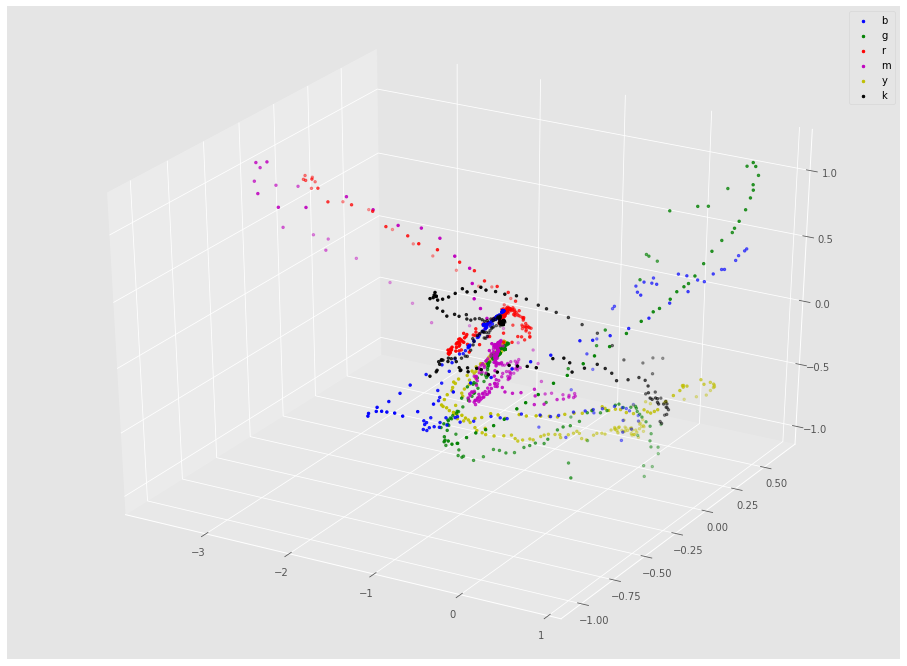

In [64]:
fig = plt.figure(figsize=(16, 12))
ax = fig.gca(projection='3d')
for centroid in model.centroids:
    #for i in range(model.centroids[0].shape[0]):
    #    ax.scatter(model.centroids[centroid][i][0], model.centroids[centroid][i][1], model.centroids[centroid][i][2], marker="o", color=colors[centroid], s=2, linewidths=1, label=colors[centroid])
    ax.scatter(model.centroids[centroid][:,0], model.centroids[centroid][:,1], model.centroids[centroid][:,2], marker="o", color=colors[centroid], s=6, linewidths=1, label=colors[centroid])
        
        
        
        
# for classification in model.classifications:
#     color = colors[classification]
#     for featureset in model.classifications[classification]:
#         #plt.scatter(featureset[0], featureset[1],featureset[2], marker="x", color=color, s=150, linewidths=5)
#         ax.scatter(featureset[0], featureset[1],featureset[2], marker="x", color=color, s=150, linewidths=5)
ax.legend()
plt.show()

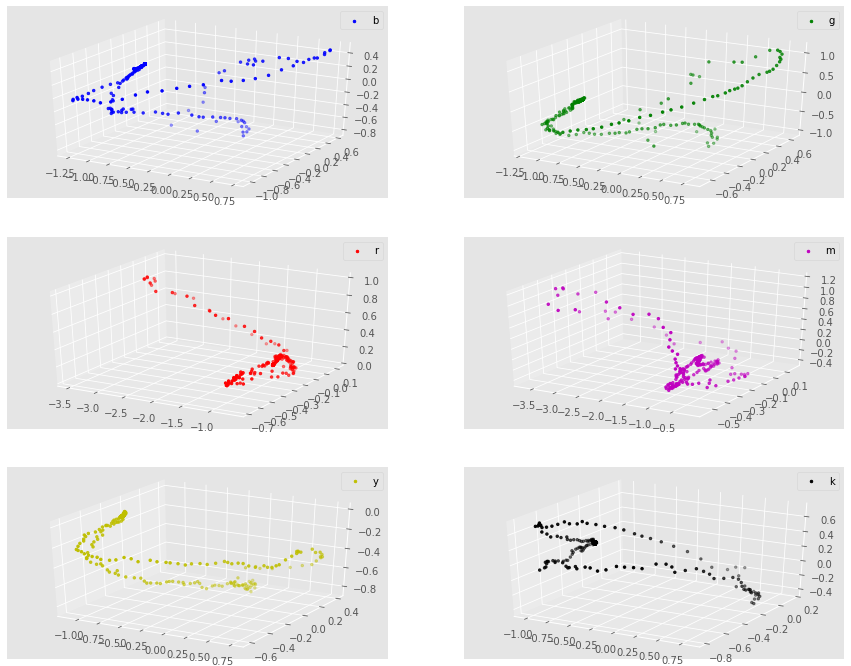

In [86]:
# 각 centroid 나눈 것
fig = plt.figure(figsize=(15, 12))
ax = fig.add_subplot(321, projection='3d')
centroid=0
ax.scatter(model.centroids[centroid][:,0], model.centroids[centroid][:,1], model.centroids[centroid][:,2], marker="o", color=colors[centroid], s=6, linewidths=1, label=colors[centroid])
ax.legend()

ax = fig.add_subplot(322, projection='3d')
centroid=1
ax.scatter(model.centroids[centroid][:,0], model.centroids[centroid][:,1], model.centroids[centroid][:,2], marker="o", color=colors[centroid], s=6, linewidths=1, label=colors[centroid])
ax.legend()

ax = fig.add_subplot(323, projection='3d')
centroid=2
ax.scatter(model.centroids[centroid][:,0], model.centroids[centroid][:,1], model.centroids[centroid][:,2], marker="o", color=colors[centroid], s=6, linewidths=1, label=colors[centroid])
ax.legend()

ax = fig.add_subplot(324, projection='3d')
centroid=3
ax.scatter(model.centroids[centroid][:,0], model.centroids[centroid][:,1], model.centroids[centroid][:,2], marker="o", color=colors[centroid], s=6, linewidths=1, label=colors[centroid])
ax.legend()

ax = fig.add_subplot(325, projection='3d')
centroid=4
ax.scatter(model.centroids[centroid][:,0], model.centroids[centroid][:,1], model.centroids[centroid][:,2], marker="o", color=colors[centroid], s=6, linewidths=1, label=colors[centroid])
ax.legend()

ax = fig.add_subplot(326, projection='3d')
centroid=5
ax.scatter(model.centroids[centroid][:,0], model.centroids[centroid][:,1], model.centroids[centroid][:,2], marker="o", color=colors[centroid], s=6, linewidths=1, label=colors[centroid])
ax.legend()



plt.show()

In [115]:
# 각 액션 샘플들 32개씩 모아서 보기
proc_sample_1 = np.empty((6, 32,proc_acc.shape[1],proc_acc.shape[2]), dtype=float)
print(proc_sample_1.shape)

(6, 32, 280, 3)


In [121]:
for i in range(proc_acc.shape[0]):
    y_true = i//32
    index = i%32
    proc_sample_1[y_true][index]=proc_acc[i]

In [131]:
print(proc_sample_1[0].shape)
#print(proc_sample_1[0][31][:,0])
print(proc_sample_1.shape[1])
print(proc_sample_1[0][31][:,0].shape)
print(proc_sample_1[0][0][:,1].shape)
print(proc_sample_1[0][0][:,2].shape)

(32, 280, 3)
32
(280,)
(280,)
(280,)


(280,) (280,) (32, 3)


<function matplotlib.pyplot.show(*args, **kw)>

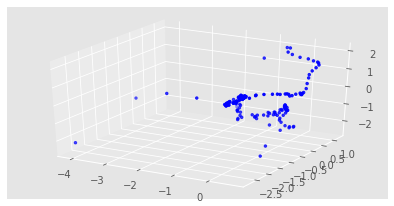

In [135]:
print(proc_sample_1[centroid][i][:,0].shape, proc_sample_1[centroid][i][:,1].shape, proc_sample_1[centroid][:,2].shape)
fig = plt.figure(figsize=(15, 12))
ax = fig.add_subplot(321, projection='3d')
centroid=0
i=0
ax.scatter(proc_sample_1[centroid][i][:,0], proc_sample_1[centroid][i][:,1], proc_sample_1[centroid][i][:,2], marker="o", color=colors[centroid], s=6, linewidths=1, label=colors[centroid])
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

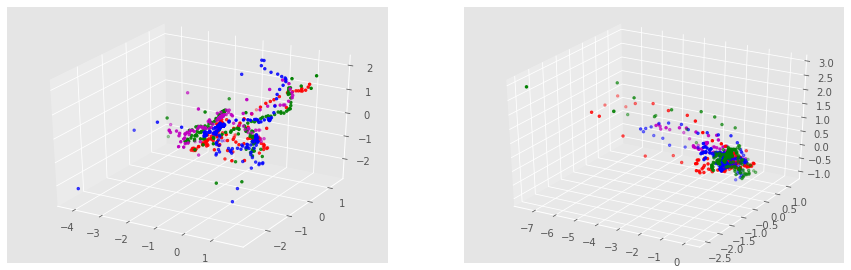

In [144]:
fig = plt.figure(figsize=(15, 16))
ax = fig.add_subplot(321, projection='3d')
centroid=0
for i in range(4):
    j=4*i
    ax.scatter(proc_sample_1[centroid][j][:,0], proc_sample_1[centroid][j][:,1], proc_sample_1[centroid][j][:,2], marker="o", color=colors[i], s=6, linewidths=1, label=colors[centroid])


ax = fig.add_subplot(322, projection='3d')
centroid=2
for i in range(4):
    j=4*i
    ax.scatter(proc_sample_1[centroid][j][:,0], proc_sample_1[centroid][j][:,1], proc_sample_1[centroid][j][:,2], marker="o", color=colors[i], s=6, linewidths=1, label=colors[centroid])

plt.show

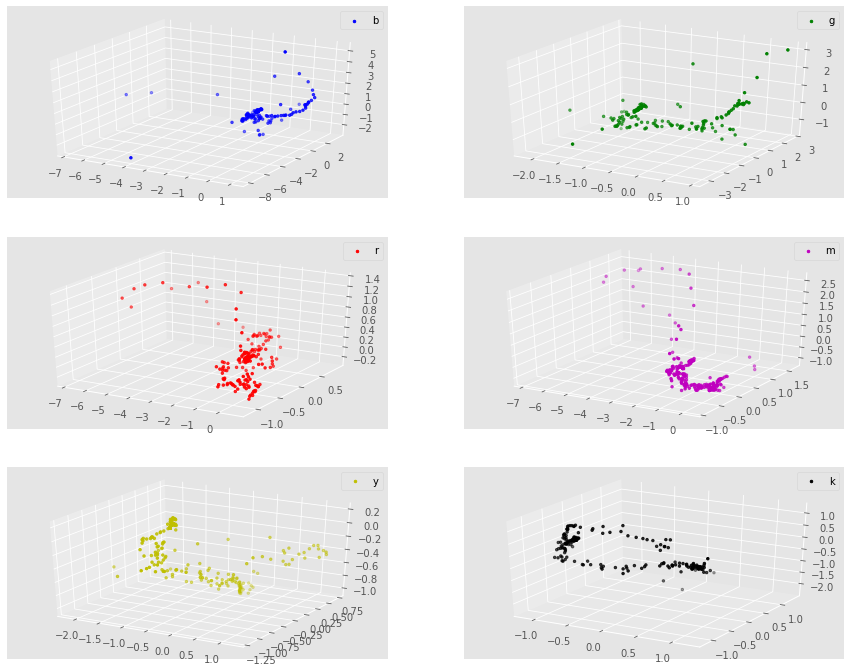

In [98]:
fig = plt.figure(figsize=(15, 12))
ax = fig.add_subplot(321, projection='3d')
centroid=0
ax.scatter(samples[centroid][:,0], samples[centroid][:,1], samples[centroid][:,2], marker="o", color=colors[centroid], s=6, linewidths=1, label=colors[centroid])
ax.legend()

ax = fig.add_subplot(322, projection='3d')
centroid=1
ax.scatter(samples[centroid][:,0], samples[centroid][:,1], samples[centroid][:,2], marker="o", color=colors[centroid], s=6, linewidths=1, label=colors[centroid])
ax.legend()

ax = fig.add_subplot(323, projection='3d')
centroid=2
ax.scatter(samples[centroid][:,0], samples[centroid][:,1], samples[centroid][:,2], marker="o", color=colors[centroid], s=6, linewidths=1, label=colors[centroid])
ax.legend()

ax = fig.add_subplot(324, projection='3d')
centroid=3
ax.scatter(samples[centroid][:,0], samples[centroid][:,1], samples[centroid][:,2], marker="o", color=colors[centroid], s=6, linewidths=1, label=colors[centroid])
ax.legend()

ax = fig.add_subplot(325, projection='3d')
centroid=4
ax.scatter(samples[centroid][:,0], samples[centroid][:,1], samples[centroid][:,2], marker="o", color=colors[centroid], s=6, linewidths=1, label=colors[centroid])
ax.legend()

ax = fig.add_subplot(326, projection='3d')
centroid=5
ax.scatter(samples[centroid][:,0], samples[centroid][:,1], samples[centroid][:,2], marker="o", color=colors[centroid], s=6, linewidths=1, label=colors[centroid])
ax.legend()



plt.show()

In [140]:
print(sample)

NameError: name 'sample' is not defined

In [147]:
axis_x = np.linspace(0, 279, 280)
print(axis_x)
print(proc_ax.shape)

[  0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.
  42.  43.  44.  45.  46.  47.  48.  49.  50.  51.  52.  53.  54.  55.
  56.  57.  58.  59.  60.  61.  62.  63.  64.  65.  66.  67.  68.  69.
  70.  71.  72.  73.  74.  75.  76.  77.  78.  79.  80.  81.  82.  83.
  84.  85.  86.  87.  88.  89.  90.  91.  92.  93.  94.  95.  96.  97.
  98.  99. 100. 101. 102. 103. 104. 105. 106. 107. 108. 109. 110. 111.
 112. 113. 114. 115. 116. 117. 118. 119. 120. 121. 122. 123. 124. 125.
 126. 127. 128. 129. 130. 131. 132. 133. 134. 135. 136. 137. 138. 139.
 140. 141. 142. 143. 144. 145. 146. 147. 148. 149. 150. 151. 152. 153.
 154. 155. 156. 157. 158. 159. 160. 161. 162. 163. 164. 165. 166. 167.
 168. 169. 170. 171. 172. 173. 174. 175. 176. 177. 178. 179. 180. 181.
 182. 183. 184. 185. 186. 187. 188. 189. 190. 191. 192. 193. 194. 195.
 196. 

<function matplotlib.pyplot.show(*args, **kw)>

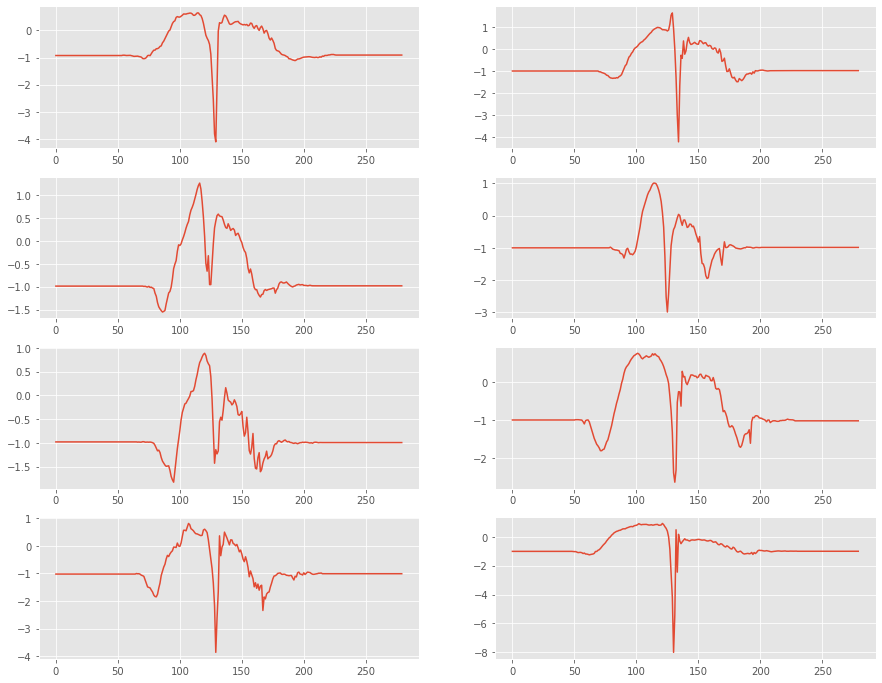

In [156]:
fig = plt.figure(figsize=(15, 12))
ax = fig.add_subplot(421)
ax.plot(axis_x, proc_ax[0])

ax = fig.add_subplot(422)
ax.plot(axis_x, proc_ax[4])

ax = fig.add_subplot(423)
ax.plot(axis_x, proc_ax[8])

ax = fig.add_subplot(424)
ax.plot(axis_x, proc_ax[12])

ax = fig.add_subplot(425)
ax.plot(axis_x, proc_ax[16])

ax = fig.add_subplot(426)
ax.plot(axis_x, proc_ax[20])

ax = fig.add_subplot(427)
ax.plot(axis_x, proc_ax[24])

ax = fig.add_subplot(428)
ax.plot(axis_x, proc_ax[28])


plt.show